In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 6) # (w, h)
from textwrap import wrap
from scipy.signal import butter, filtfilt


In [2]:
FREQ_BANDS = ["delta","theta","alpha","beta","gamma"]
DELTA_BAND = [0.5,4]
THETA_BAND = [4,8]
ALPHA_BAND = [8,12]
BETA_BAND = [12,35]
GAMMA_BAND = [35,119]

def get_band_frequencies(band_name):
    """
    Parameters
    ----------
    band_name : string
        The desired frequency band
        
    Returns
    -------
    A list with the min and max frequency for the desired frequency band. 

    """
    band_name = band_name.lower()
    
    # assert that band argument is correct
    possible_freq_bands = ["alpha","beta","gamma","delta","theta"]
    freq_bands = " -- ".join(possible_freq_bands)
    assert(band_name in possible_freq_bands), "This is not a valid frequency band. Possible frequency bands : "+freq_bands
    
    if band_name == 'alpha':
        return ALPHA_BAND
    elif band_name == 'beta':
        return BETA_BAND
    elif band_name == 'gamma':
        return GAMMA_BAND
    elif band_name == 'delta':
        return DELTA_BAND
    elif band_name == 'theta':
        return THETA_BAND
    
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    #     y = lfilter(b, a, data)
    y = filtfilt(b,a, data,axis=0)

    return y

def get_raw_eeg_mindmonitor(file_path):
    usecols=np.arange(21,25) # 4 raw inputs

    eeg_rec = np.genfromtxt(file_path, delimiter=',', skip_header = 1, usecols=usecols)
    non_nan_rows = ~np.isnan(eeg_rec).any(axis=1)
    eeg_rec = eeg_rec[non_nan_rows] # Remove nan rows

    # Process timestamps
    timestamps = np.genfromtxt(data_path + file_name, delimiter=',', skip_header = 1, usecols=[0],dtype=str)
    timestamps = timestamps[non_nan_rows]
    timestamps = [np.datetime64(x) for x in timestamps]
    timestamps = timestamps - timestamps[0]
    timestamps = timestamps/np.timedelta64(1,'s')
    
    return eeg_rec,timestamps

def plot_muse(raw_data,freqs, f_samp,labels, title='', eeg_plots=['freq','time','score']):
    
    
    # Filtering
    f_low=0.5
    f_high=40 
    eeg_filt=butter_bandpass_filter(raw_data,f_low,f_high,f_samp)
    if set(['freq', 'score']) & set(eeg_plots):
        eeg_fft = np.abs(np.fft.rfft(eeg_filt.copy(),axis=0))
 
    # EEG Plots
    fig = plt.figure(figsize=[14,8])
    fig.tight_layout(pad=0.5)
    
    for ind, plot_type in enumerate(eeg_plots):
        plot_nb = int(f'{len(eeg_plots)}1{ind+1}')
        
        # Plot Frequency domain
        if plot_type =='freq':
            ax = plt.subplot(plot_nb)
            eeg_plot_psd(eeg_fft, freqs, f_samp,ax)
            fig.tight_layout(pad=0.5)

        # Time domain
        elif plot_type =='time':
            ax1=plt.subplot(plot_nb)
            eeg_plot_time_domain(eeg_filt, f_samp, ax1)
            fig.tight_layout(pad=0.5)

        # Score 
        elif plot_type =='score':
            ax2 =plt.subplot(plot_nb)
            eeg_plot_scores(eeg_fft,freqs,labels,ax2)
            
    plt.show()

    return 

def eeg_plot_psd(eeg_fft, freqs, f_samp, ax,title=''):
    
    # Plot Frequency domain
    eeg_norm=eeg_fft/eeg_fft.sum(axis=0)[np.newaxis,:] #normalize 
    a=ax.plot(freqs,eeg_norm,alpha=1,linewidth=1,color='k',label='_nolegend_')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('\n'.join(wrap('Power Spectrum Density',12)))
    ax.set_title(title)
    ax.set_xlim(0,60)
    ax.set_ylim(0,0.05)

    for ind,band in enumerate(FREQ_BANDS):
        freq_limit = get_band_frequencies(band)
        ax.axvspan(freq_limit[0],freq_limit[1],color=f'C0{ind}',alpha=0.2,label=band)
    ax.legend(loc='upper right',fontsize=15)
    return 

def eeg_plot_time_domain(eeg,f_samp,ax):
    
    t_eeg = np.arange(0, eeg.shape[0]/ f_samp, step=1/f_samp)
    ax.plot(t_eeg,eeg)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel(r'EEG [$\mu$V]')
    ax.set_ylim(-100,100)

def eeg_plot_scores(eeg_fft,freqs,labels, ax):
    
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
    score_array = np.zeros((len(FREQ_BANDS),4))
    x = np.arange(len(FREQ_BANDS))*0.5
    colors=[f'C0{x}' for x in range(5)]
    width=0.1
    for ind,band in enumerate(FREQ_BANDS):
        score = get_band_score(eeg_fft,freqs, band=band)
        score_array[ind] = score
    for channel in range(4):
        ax.bar(x+channel*width,100*score_array[:,channel],label=labels[channel],width=width,color=colors,alpha=1-channel*0.2)
    
    ax.set_xticks(x)
    ax.set_xticklabels(FREQ_BANDS)
    ax.set_ylabel('Score [%]')
    ax.set_xlabel('Frequency Band')
    ax.legend(loc='center left',bbox_to_anchor=(1,0.5))
    ax.grid(visible=True,which='both',axis='y')

def get_band_score(filtered_signal_fft,freqs, band='alpha'):
    band_freq = get_band_frequencies(band)
    filterband=np.zeros((freqs.shape))
    filterband[np.where((freqs>band_freq[0])&(freqs<band_freq[1]))] = 1
    filterband = np.tile(filterband,(filtered_signal_fft.shape[-1],1)).T
    filtered_signal_fft = filtered_signal_fft/filtered_signal_fft.sum(axis=0)[np.newaxis,:]
    band_values = filterband*filtered_signal_fft
    return band_values.sum(axis=0)

In [3]:
data_path = '../2-Data/1-RawData/mindmonitor/'
file_name = 'museMonitor_2022-02-13--00-07-42_2125283859146790822.csv'

eeg_rec, timestamps = get_raw_eeg_mindmonitor(data_path+file_name)

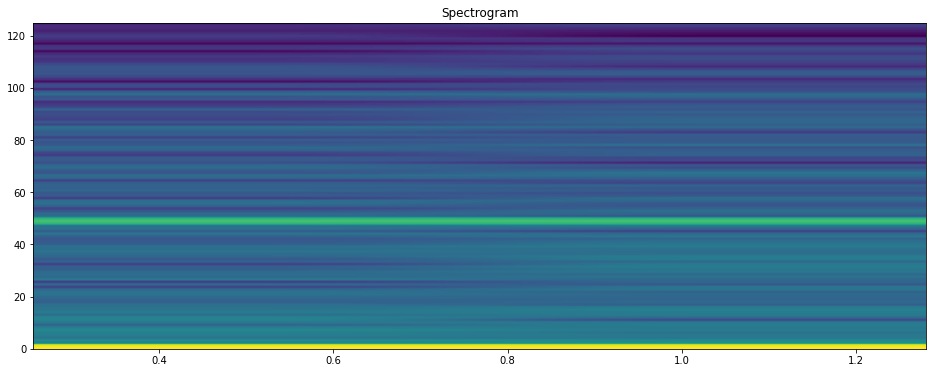

In [4]:
b= slice(1600,2000)
channel = 0
f_samp = 250
plt.specgram(eeg_rec[b,channel],Fs=f_samp,mode='psd',scale='dB')
plt.title('Spectrogram')
plt.show()

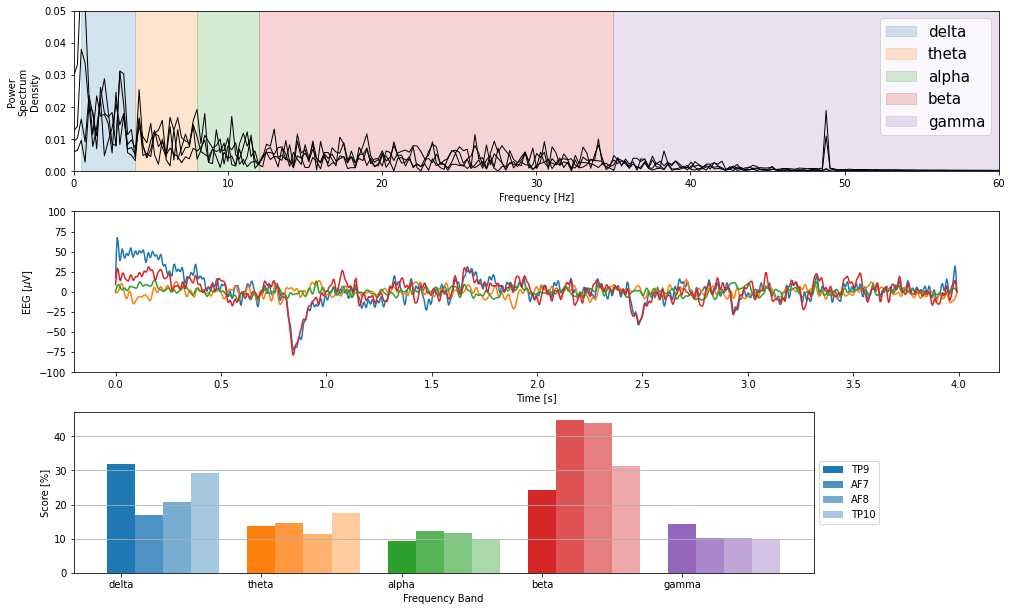

In [5]:
b=slice(1,1000)
# b=slice(None)
freqs = np.fft.rfftfreq(eeg_rec[b].shape[0], 1/f_samp)
labels = ['TP9','AF7','AF8','TP10']
plot_muse(eeg_rec[b],freqs, f_samp,labels, title='', eeg_plots=['freq','time','score'])